In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [18]:
df = pd.read_csv("../data/AEP.csv")
df

,Date,AEP_MW
0,2004-10-31,10349073.0
1,2004-11-30,10677917.0
2,2004-12-31,12452864.0
3,2005-01-31,12735114.0
4,2005-02-28,11085745.0
...,...,...
162,2018-04-30,9820256.0
163,2018-05-31,10503052.0
164,2018-06-30,11019780.0
165,2018-07-31,11849407.0


In [19]:
df.iloc[-5:]

,Date,AEP_MW
162,2018-04-30,9820256.0
163,2018-05-31,10503052.0
164,2018-06-30,11019780.0
165,2018-07-31,11849407.0
166,2018-08-31,754941.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    167 non-null    object 
 1   AEP_MW  167 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB


In [21]:
df.isna().sum()

Date      0
AEP_MW    0
dtype: int64

In [22]:
df["Date"] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167 entries, 2004-10-31 to 2018-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AEP_MW  167 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


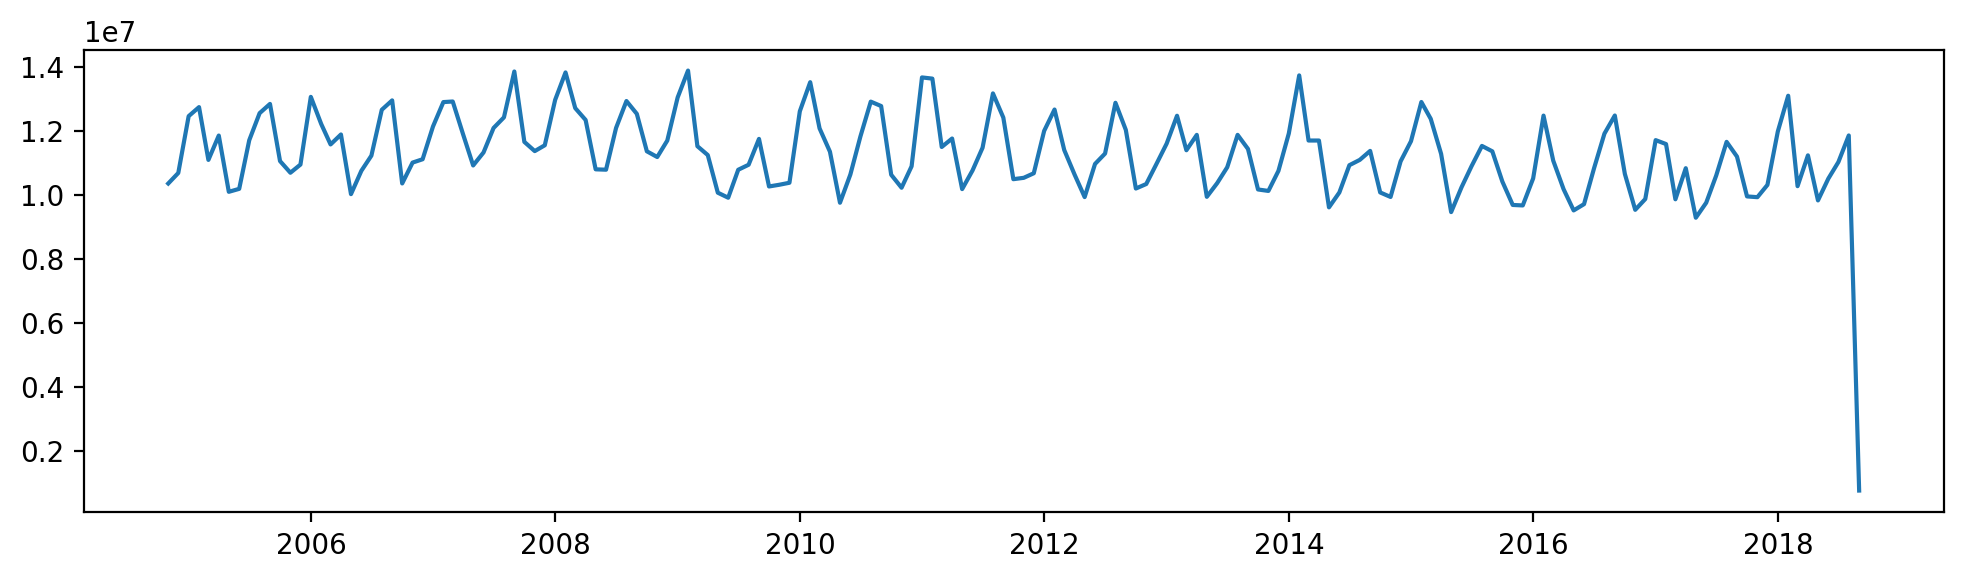

In [24]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
ax.plot(df)

In [25]:
df = df[:-1]

In [26]:
df

,AEP_MW
Date,
2004-10-31,10349073.0
2004-11-30,10677917.0
2004-12-31,12452864.0
2005-01-31,12735114.0
2005-02-28,11085745.0
...,...
2018-03-31,11228646.0
2018-04-30,9820256.0
2018-05-31,10503052.0


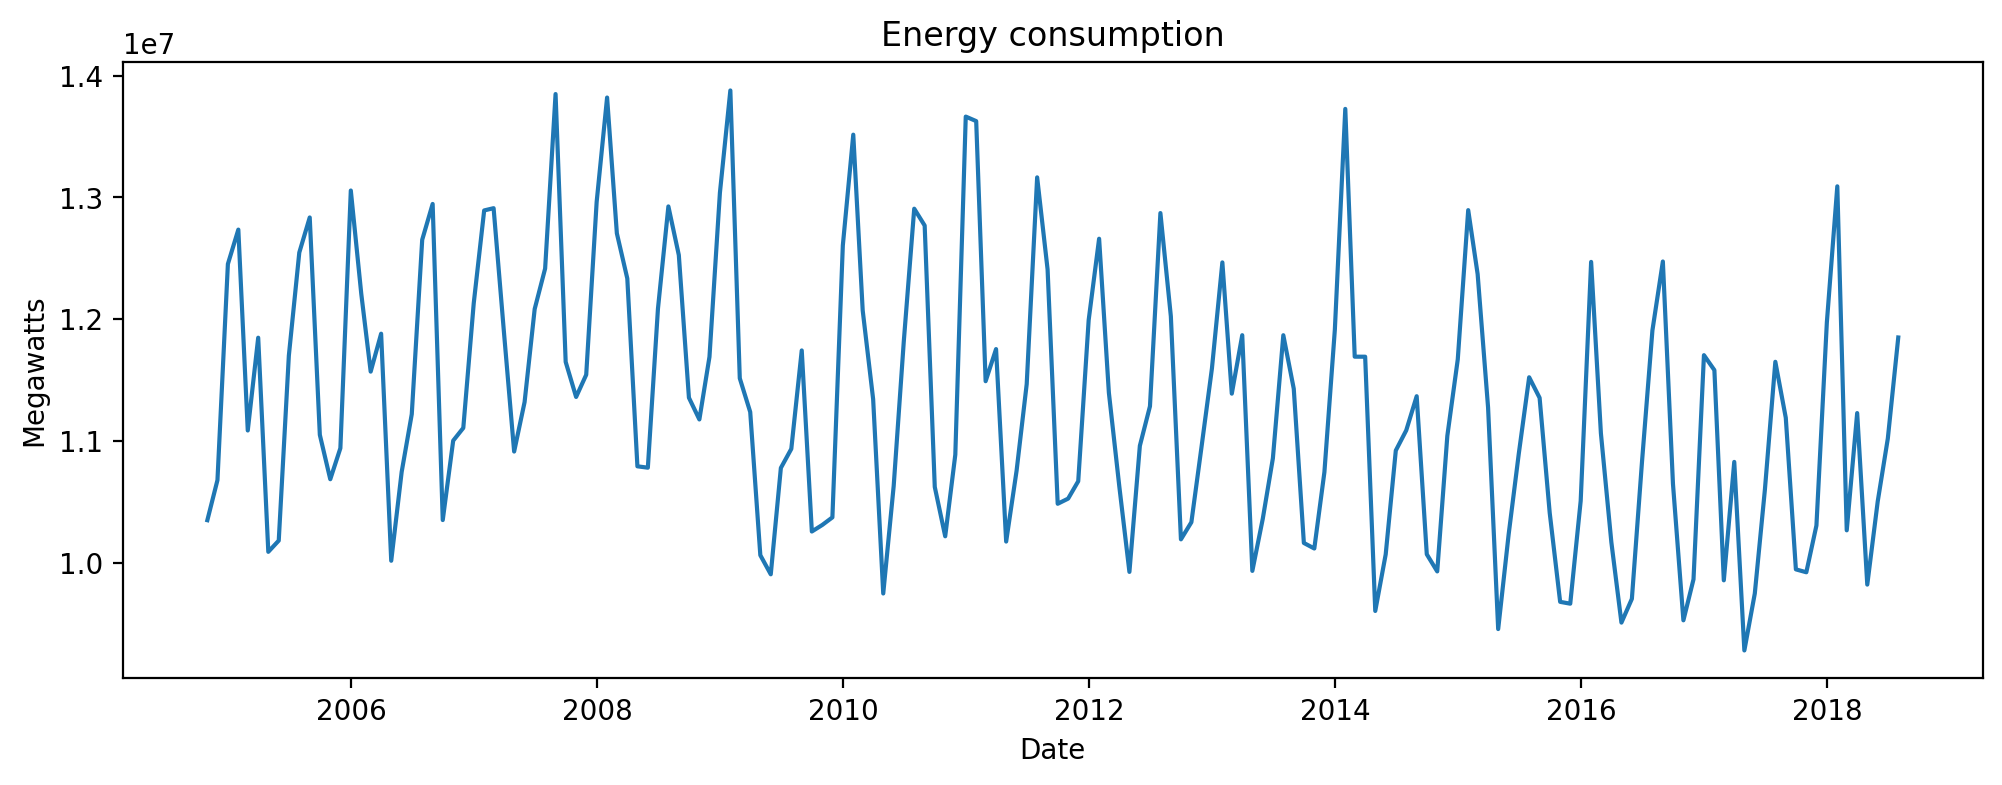

In [27]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)
ax.plot(df)

# Labelling
plt.xlabel("Date")
plt.ylabel("Megawatts")
plt.title("Energy consumption")
plt.show()


In [28]:
# Seasonal decomposition
result = seasonal_decompose(
    df['AEP_MW'],
    model='additive',
    period=12,
    extrapolate_trend='freq'
)


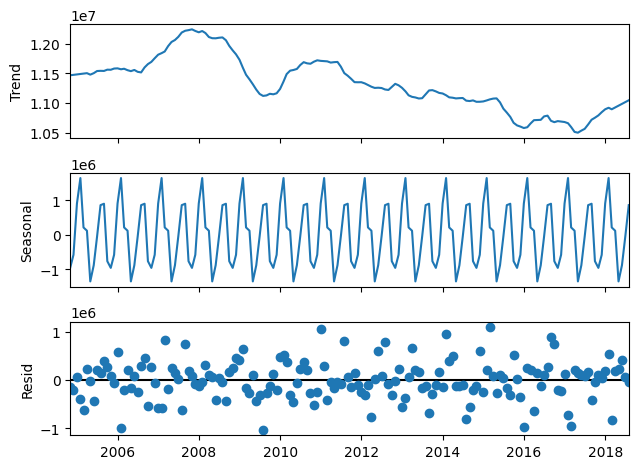

In [29]:
result.plot(observed=False)
plt.show()

In [30]:
# Differentiating the data once
df_dif = df['AEP_MW'] - df['AEP_MW'].shift(1)
print(df_dif[:10])
df_dif = df_dif - df_dif.shift(5)
print("=="*30)
print(df_dif[:10])
df_dif = df_dif.dropna()
print("=="*30)
print(df_dif[:10])

Date
2004-10-31          NaN
2004-11-30     328844.0
2004-12-31    1774947.0
2005-01-31     282250.0
2005-02-28   -1649369.0
2005-03-31     761757.0
2005-04-30   -1758190.0
2005-05-31      92382.0
2005-06-30    1518546.0
2005-07-31     846482.0
Name: AEP_MW, dtype: float64
Date
2004-10-31          NaN
2004-11-30          NaN
2004-12-31          NaN
2005-01-31          NaN
2005-02-28          NaN
2005-03-31          NaN
2005-04-30   -2087034.0
2005-05-31   -1682565.0
2005-06-30    1236296.0
2005-07-31    2495851.0
Name: AEP_MW, dtype: float64
Date
2005-04-30   -2087034.0
2005-05-31   -1682565.0
2005-06-30    1236296.0
2005-07-31    2495851.0
2005-08-31    -473668.0
2005-09-30     -26679.0
2005-10-31    -456957.0
2005-11-30   -1263598.0
2005-12-31    1269353.0
2006-01-31   -1135321.0
Name: AEP_MW, dtype: float64


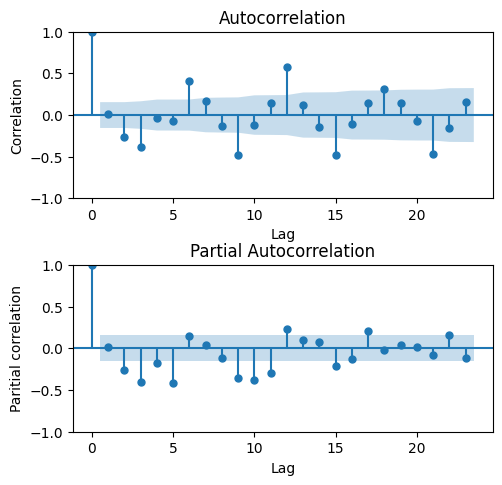

In [31]:
# Plotting ACF and PACF
fig = plt.figure(figsize=(6,5))

ax1 = fig.add_subplot(211)
ax1.set_xlabel('Lag')
ax1.set_ylabel('Correlation')
plot_acf(df_dif, ax=ax1, alpha=0.05)

ax2 = fig.add_subplot(212)
ax2.set_xlabel('Lag')
ax2.set_ylabel('Paritial correlation')
plot_pacf(df_dif, ax=ax2, alpha=0.05)

plt.subplots_adjust(left=0.2,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

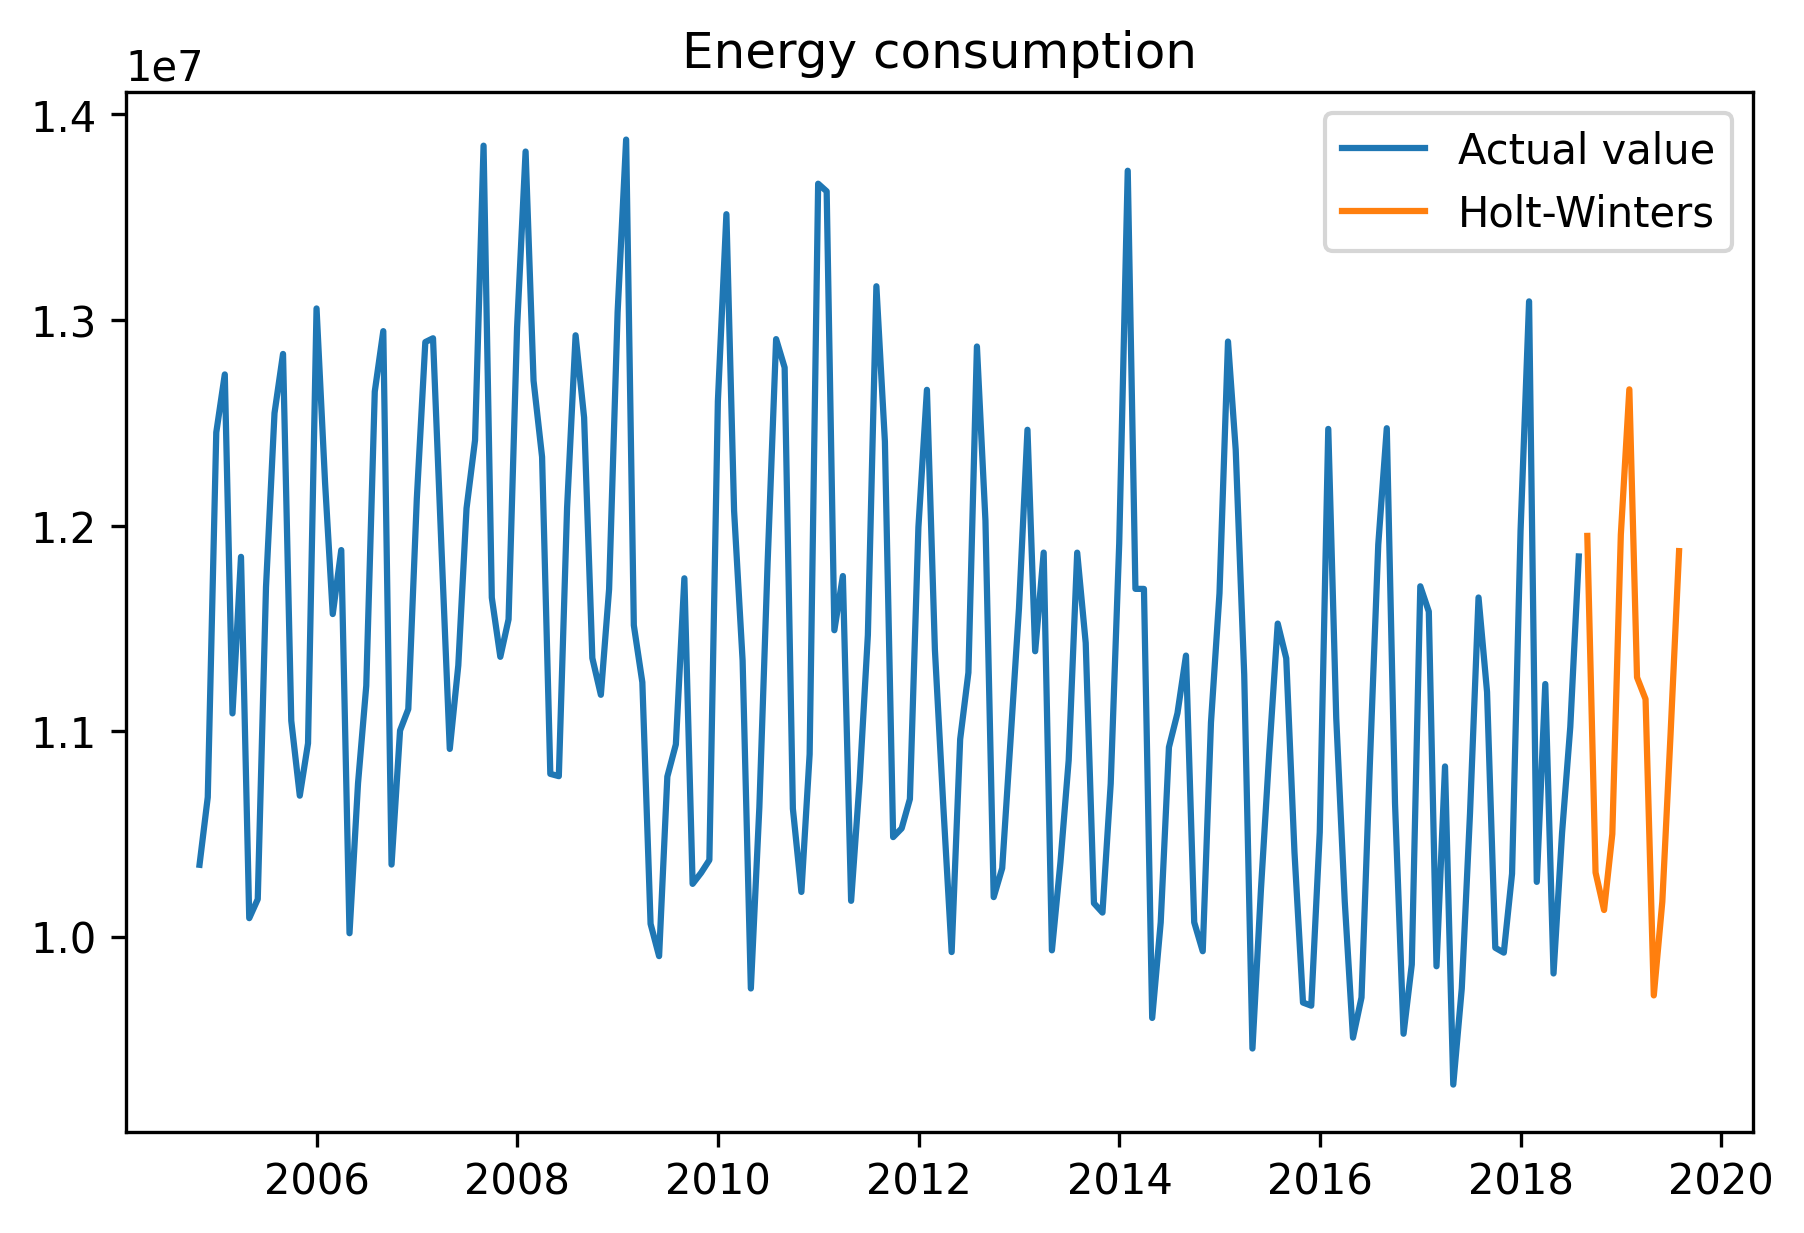

In [34]:
from datetime import timedelta
# Forecasting with Holt-Winters
freq=12
hw_results = ExponentialSmoothing(
    df['AEP_MW'],
    trend='multiplicative',
    seasonal='multiplicative', freq='ME').fit()

hw_predictions = hw_results.predict(
    start=df.index.max()+timedelta(days=30),
    end=df.index.max()+timedelta(days=12*30)
    )

# Plotting
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=300)

ax.plot(df['AEP_MW'], label = "Actual value")
ax.plot(hw_predictions, label = "Holt-Winters")
plt.title("Energy consumption")

plt.legend()
fig.savefig("multi.png")

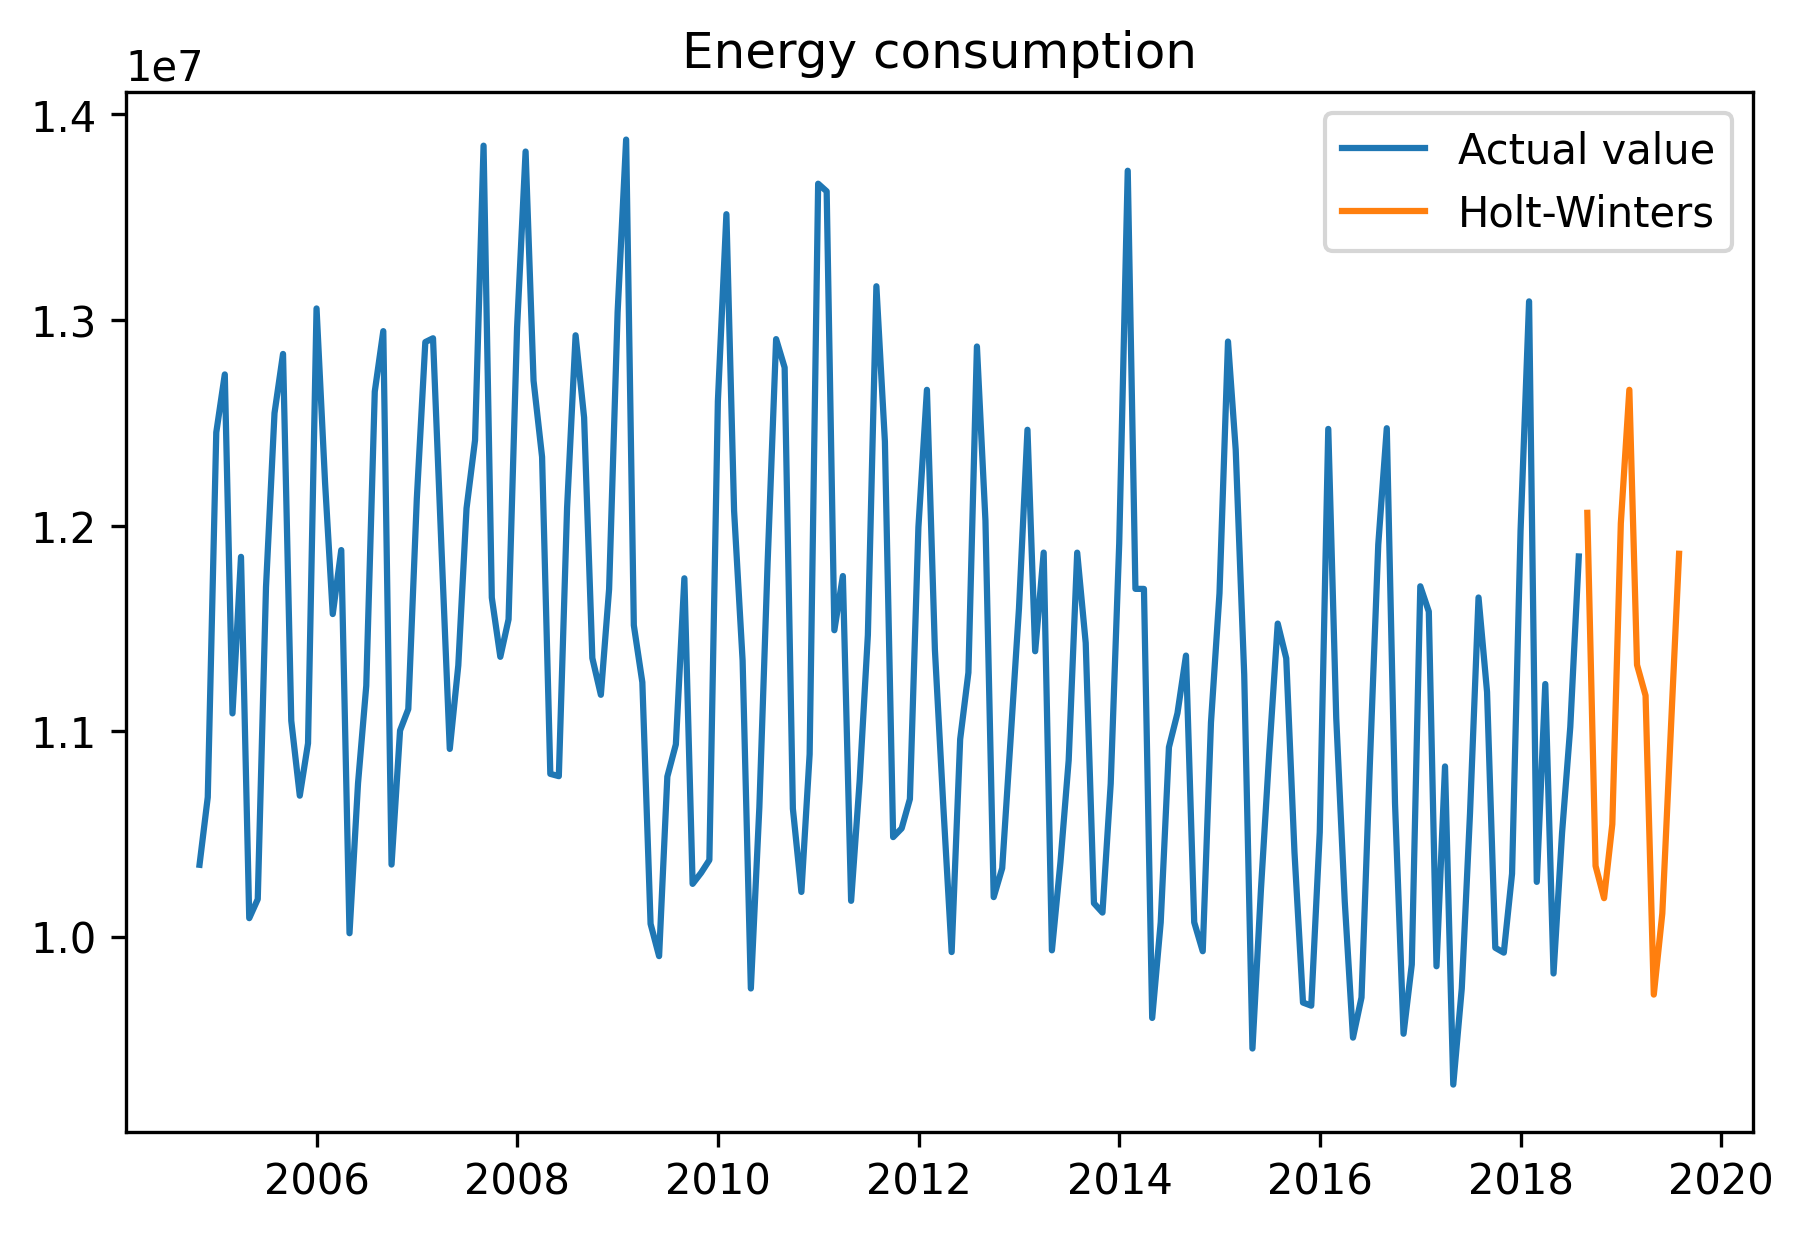

In [35]:
from datetime import timedelta
# Forecasting with Holt-Winters
freq=12
hw_results = ExponentialSmoothing(
    df['AEP_MW'],
    trend='additive',
    seasonal='additive', freq='ME').fit()

hw_predictions = hw_results.predict(
    start=df.index.max()+timedelta(days=30),
    end=df.index.max()+timedelta(days=12*30)
    )

# Plotting
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=300)

ax.plot(df['AEP_MW'], label = "Actual value")
ax.plot(hw_predictions, label = "Holt-Winters")
plt.title("Energy consumption")

plt.legend()
fig.savefig("add.png")